In [3]:
from thefuzz import fuzz
import matplotlib.pyplot as plt
from collections import Counter
import json
import csv

In [28]:
# test the fuzz function
# fuzz.ratio("typological classification", "soil classification") #???
fuzz.ratio("water", "wasser")

73

In [6]:
# format string
def formatString(input_string):
    # Strip leading whitespace first
    stripped_string = input_string.lstrip()
    
    # Check if the stripped string starts with a number
    if stripped_string and stripped_string[0].isdigit():
        # Remove leading numbers
        return stripped_string.lstrip('0123456789')
    
    # If no leading numbers, return the original stripped string
    return input_string.lstrip()

formatString('s123oiltype')

's123oiltype'

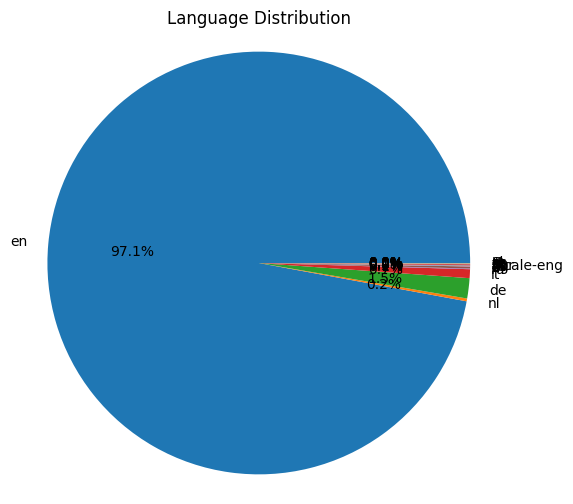

In [2]:
# Calculate the count of each languages in the missed keywords
with open("mis_keys.json", "r") as f:
    keys = json.load(f)

language_counts = Counter(lang for _, lang in keys)

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(language_counts.values(), labels=language_counts.keys(), autopct='%1.1f%%')
plt.title('Language Distribution')
plt.axis('equal')
plt.show()

In [3]:
# analyze english label:
en_keys = [item[0].lower() for item in keys if item[1] == "en"] # lower case
label_counts = Counter(en_keys)

lower_keys = [item.lower() for item in en_keys]
print(len(set(lower_keys)))


sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)

print("Label Counts (sorted from high to low):")
for label, count in sorted_labels:
    print(f"{label}: {count}")

16791
Label Counts (sorted from high to low):
04 agricultural and veterinary sciences: 5872
0401 agriculture, forestry, and fisheries: 5737
040103 agronomy & agriculture: 5218
01 natural sciences: 4172
04010301 horticulture/soil: 3466
0105 earth and related environmental sciences: 2394
0106 biological sciences: 1856
010603 evolutionary biology: 1159
04010302 agroecology/sustainable agriculture: 1120
01060301 forests/habitats: 1057
010501 environmental sciences: 1007
02 engineering and technology: 955
03 medical and health sciences: 810
0301 basic medicine: 785
01050102 sanitation/water pollution: 761
010504 meteorology & atmospheric sciences: 576
0303 health sciences: 527
0211 other engineering and technologies: 458
soil types: 457
agriculture: 447
01050408 carbon cycle/chemical oceanography: 431
010606 plant biology & botany: 429
15. life on land: 348
biomass: 334
soil microbiology: 312
2. zero hunger: 270
ecology: 268
0202 electrical engineering, electronic engineering, information e

In [4]:
from collections import Counter


# read match.json and concepts.json
with open("match.json", "r") as f:
    match = json.load(f)

with open("concepts.json", "r") as f:
    cons = json.load(f)

# find all the matched terms
terms = [match_terms['concept_identifier'] for match_terms in match]
counts = Counter(terms)
print(len(counts))

158


In [11]:
idenfiers = [item for item, count in counts.items()]

a=  []

for i in idenfiers:
    for j in cons:
        if i == j['idenfier']: # find a match
            label = j['labels']['en'][0]
            print(i, label)



['https://soilwise-he.github.io/soil-health#Soil', 'https://soilwise-he.github.io/soil-health#IntrinsicSoilProperties', 'https://soilwise-he.github.io/soil-health#Mineralization', 'https://soilwise-he.github.io/soil-health#MicrobialBiomass', 'https://soilwise-he.github.io/soil-health#SoilPollution', 'https://soilwise-he.github.io/soil-health#SoilOrganicMatter', 'https://soilwise-he.github.io/soil-health#Decomposition', 'https://soilwise-he.github.io/soil-health#OrganicCarbon', 'https://soilwise-he.github.io/soil-health#Carbon', 'https://soilwise-he.github.io/soil-health#Water', 'https://soilwise-he.github.io/soil-health#Compaction', 'https://soilwise-he.github.io/soil-health#MineralFertilisers', 'https://soilwise-he.github.io/soil-health#DevelopingCountries', 'https://soilwise-he.github.io/soil-health#SoilOrganicCarbon', 'https://soilwise-he.github.io/soil-health#Biodiversity', 'https://soilwise-he.github.io/soil-health#ChemicalCompositionOfSoc', 'https://soilwise-he.github.io/soil-hea

In [ ]:
with open("match.json", "r") as f:
    match_data = json.load(f)

with open("concepts.json", "r") as f:
    terms_data = json.load(f)


def process_terms(terms_data, match_data, output_file):
    
    # Create a dictionary to map concept identifiers to their first relevant URI
    concept_uris = {}
    for term in terms_data:
        concept_uris[term['identifier']] = term.get('relevant_uris', [None])[0]
    
    # Count occurrences of terms
    term_counts = defaultdict(int)
    for match in match_data:
        term_counts[match['label']] += 1
    
    # Prepare output data
    output_data = []
    processed_terms = set()
    
    for match in match_data:
        term = match['label']
        
        # Skip if term already processed
        if term in processed_terms:
            continue
        
        # Find URI for this term's concept
        uri = concept_uris.get(match['concept_identifier'])
        
        # Add to output data
        output_data.append({
            'Term': term,
            'URI': uri or '',
            'Count': term_counts[term],
            'Class': ''
        })
        
        processed_terms.add(term)
    
    # Write to CSV
    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=['Term', 'URI', 'Count', 'Class'])
        writer.writeheader()
        writer.writerows(output_data)
    
    print(f"Processed {len(output_data)} unique terms to {output_file}")

# Usage
process_terms('terms.json', 'match.json', 'terms.csv')